In [1]:
![ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
from fastbook import *

# A Language Model from Scratch

## The Data

In [3]:
from fastai.text.all import *

In [4]:
URLs.HUMAN_NUMBERS

'https://s3.amazonaws.com/fast-ai-sample/human_numbers.tgz'

In [5]:
path = untar_data(URLs.HUMAN_NUMBERS)
path

Path('/root/.fastai/data/human_numbers')

In [6]:
Path.BASE_PATH = path
path

Path('.')

In [7]:
path.ls()

(#2) [Path('valid.txt'),Path('train.txt')]

In [8]:
lines = L()
with open(path/'train.txt') as f:
    lines += L(*f.readlines())
with open(path/'valid.txt') as f:
    lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

In [9]:
lines[-10:]

(#10) ['nine thousand nine hundred ninety \n','nine thousand nine hundred ninety one \n','nine thousand nine hundred ninety two \n','nine thousand nine hundred ninety three \n','nine thousand nine hundred ninety four \n','nine thousand nine hundred ninety five \n','nine thousand nine hundred ninety six \n','nine thousand nine hundred ninety seven \n','nine thousand nine hundred ninety eight \n','nine thousand nine hundred ninety nine \n']

In [10]:
text = " . ".join([l.strip() for l in lines])
text[:100]

'one . two . three . four . five . six . seven . eight . nine . ten . eleven . twelve . thirteen . fo'

In [11]:
tokens = text.split(" ")
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [12]:
len(tokens)

63095

In [13]:
tokens[-10:]

['hundred',
 'ninety',
 'eight',
 '.',
 'nine',
 'thousand',
 'nine',
 'hundred',
 'ninety',
 'nine']

In [14]:
vocab = L(*tokens).unique()
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [15]:
word2idx = {w: i for i, w in enumerate(vocab)}
nums = L(word2idx[t] for t in tokens)
nums

(#63095) [0,1,2,1,3,1,4,1,5,1...]

**Note:** The last index is `63094`.

## Our First Language Model from Scratch

In [16]:
len(tokens) - 4

63091

In [17]:
range(0, len(tokens) - 4, 3)

range(0, 63091, 3)

When `i` is `63091`, then `i + 3` is `63094`, which is the last index.

In [18]:
L((tokens[i:i + 3], tokens[i + 3]) for i in range(0, len(tokens) - 4, 3))

(#21031) [(['one', '.', 'two'], '.'),(['.', 'three', '.'], 'four'),(['four', '.', 'five'], '.'),(['.', 'six', '.'], 'seven'),(['seven', '.', 'eight'], '.'),(['.', 'nine', '.'], 'ten'),(['ten', '.', 'eleven'], '.'),(['.', 'twelve', '.'], 'thirteen'),(['thirteen', '.', 'fourteen'], '.'),(['.', 'fifteen', '.'], 'sixteen')...]

**Note:** The slice `i:i + 3` isn't inclusive of `i + 3`. (It contains tokens `i`, `i + 1` and `i + 2`.) So we're using sequences of every 3 tokens as our independent variable, and the next token as our dependent variable.

In [19]:
# For comparison:
print(tokens[:20])

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.', 'six', '.', 'seven', '.', 'eight', '.', 'nine', '.', 'ten', '.']


In [20]:
seqs = L((tensor(nums[i:i + 3]), nums[i + 3]) for i in range(0, len(nums) - 4, 3))
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

**Note:** The above can be treated as a PyTorch `Dataset`, because it has a length, and supports indexing.

In [21]:
bs = 32
cut = int(len(seqs) * 0.8)
cut

16824

In [22]:
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=bs, shuffle=False)
dls

In [23]:
dls.train

In [24]:
x, y = next(iter(dls.train))
x.shape, y.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([32, 3]), torch.Size([32]))

In [25]:
x[:3]

tensor([[0, 1, 2],
        [1, 3, 1],
        [4, 1, 5]])

**Note:** The second row is a continuation of the sequence (after the end of the first row). This data prep isn't suitable for a stateful RNN.

In [26]:
y[:3]

tensor([1, 4, 1])

**Note:** We don't have to one-hot encode the labels.

### Our Language Model in PyTorch

Let's see how the forward pass works for `nn.Embedding`:

In [27]:
i_h = nn.Embedding(len(vocab), 64)
i_h

Embedding(30, 64)

If we pass in a batch of full sequences:

In [28]:
with torch.no_grad():
    h = i_h(x)
h.shape

torch.Size([32, 3, 64])

If we pass in a batch of only the first token:

In [29]:
with torch.no_grad():
    h = i_h(x[:, 0])
h.shape

torch.Size([32, 64])

In [30]:
class LMModel1(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz) # Classification layer, a.k.a. 'head'.

    def forward(self, x): # (bs, 3)
        h = 0 + self.i_h(x[:, 0]) # (bs, n_hidden)
        h = F.relu(self.h_h(h)) # (bs, n_hidden)
        h = h + self.i_h(x[:, 1]) # (bs, n_hidden)
        h = F.relu(self.h_h(h)) # (bs, n_hidden)
        h = h + self.i_h(x[:, 2]) # (bs, n_hidden)
        h = F.relu(self.h_h(h)) # (bs, n_hidden)
        return self.h_o(h) # (bs, vocab_sz)

**Note:**

1. This is a sequence-to-vector RNN. It produces an output only for the last token in the sequence, not for every token in the sequence.
2. Each token is represented as a vector of length `n_hidden`. `n_hidden` can also be thought of as the number of channels. It should be treated as a hyperparameter.
3. This network only works for sequences of length `3`. (We shall see how to change this shortly.)
4. The slices `x[:, 0]`, `x[:, 1]` and `x[:, 2]` indicate that we're processing a batch at a time (like all neural networks), but only one token at a time.
5. The `nn.Linear` layer `self.h_h` is re-used at each time step, because this linear layer is describing how the hidden state changes (gets updated) as we go from one token to the next. So this layer is expected to learn the weights to perform this computation (for all sorts of inputs).
6. Just like in the case of `ResBlock`, the addition happens after the ReLU. (In this case, the input embedding vector of the next token is added to the ReLU activation of the current token. For this addition to work, the shapes of the two tensors must be the same. In other words, the `self.h_h` layer cannot change the number of channels, i.e., the length of the embedding vector.)
7. PyTorch's `nn.RNNCell` class is (almost, but not quite) equivalent to applying `self.h_h` and the non-linearity. (It doesn't have the for loop built in! We have to write it ourselves.) See the math of the actual operation here: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html
8. And PyTorch's <a href="https://pytorch.org/docs/stable/generated/torch.nn.RNN.html" target="_blank">nn.RNN</a> class is (almost) equivalent to stacking multiple `nn.RNNCell` layers. Only `nn.RNN` provides the `batch_first=True`, `dropout` and `bidirectional` options. If we use `nn.RNNCell`, we have to apply these manually ourselves. (The for loop is built in. We don't have to write it ourselves.)
9. From the equations in the documentations of `nn.RNNCell` and `nn.RNN`, we see that the embedding of the current token is not directly added to the previous activation. Rather, it is passed through a linear layer first. The ReLU is applied after adding the outputs of the two linear layers (one for processing the input embeddings and one for processing the hidden state). This also means that the number of embedding dimensions CAN be changed by an RNN layer (because the two linear layers inside it have the same number of output units - the `hidden_size` argument, making addition of the outputs of the two linear layers possible).
10. The input shape of `nn.RNN` is $(N, L, H_{in})$ when `batch_first=True`. In other words, it doesn't accept one token at a time. It only accepts a full sequence (of length $L$) - typically a batch of these. Its output shape is $(N, L, D∗H_{out})$, where $D=2$ if `bidirectional=True`, otherwise $1$. From the output shape, we see that it's a sequence-to-sequence RNN. But we can easily make it sequence-to-vector by ignoring the outputs of all but the last time step.
11. In a simple RNN cell, the output (at any time step) and the hidden state (at any time step) are the same thing. In an LSTM / GRU cell, they are different.

In [31]:
class SimpleRNNStateless(nn.Module):
    def __init__(self, input_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.i_h = nn.Linear(input_size, hidden_size)
        self.h_h = nn.Linear(hidden_size, hidden_size)
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.return_sequences = return_sequences

    def forward(self, x): # (bs, seq_len, input_size)
        bs, seq_len, input_size = x.shape
        h = torch.zeros((bs, self.hidden_size)) # (bs, hidden_size)
        all_hidden_states = []
        for i in range(seq_len):
            i_h = self.i_h(x[:, i]) # (bs, hidden_size)
            h_h = self.h_h(h) # (bs, hidden_size)
            if self.nonlinearity == 'tanh':
                h = torch.tanh(i_h + h_h) # (bs, hidden_size)
            else:
                h = torch.relu(i_h + h_h) # (bs, hidden_size)
            all_hidden_states.append(h)
        if self.return_sequences:
            return torch.stack(all_hidden_states, dim=1) # (bs, seq_len, hidden_size)
        else:
            return all_hidden_states[-1] # (bs, hidden_size)

In [32]:
class LMModel1Alt(nn.Module):
    def __init__(self, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = SimpleRNNStateless(input_emb_size, hidden_size, nonlinearity=nonlinearity, return_sequences=return_sequences)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        y = self.rnn(input_emb) # (bs, seq_len, hidden_size) if return_sequences == True else (bs, hidden_size)
        return self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)

In [33]:
class LMModel1Alt2(nn.Module):
    def __init__(self, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = nn.RNNCell(input_emb_size, hidden_size, nonlinearity=nonlinearity)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.return_sequences = return_sequences

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        bs, seq_len = x.shape
        h = torch.zeros((bs, self.hidden_size)) # (bs, hidden_size)
        all_hidden_states = []
        for i in range(seq_len):
            h = self.rnn(input_emb[:, i], h) # (bs, hidden_size)
            all_hidden_states.append(h)
        if self.return_sequences:
            y = torch.stack(all_hidden_states, dim=1) # (bs, seq_len, hidden_size)
        else:
            y = all_hidden_states[-1] # (bs, hidden_size)
        return self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)

In [34]:
class LMModel1Alt3(nn.Module):
    def __init__(self, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = nn.RNN(input_emb_size, hidden_size, num_layers=1, nonlinearity=nonlinearity, batch_first=True, dropout=0.0, bidirectional=False)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.return_sequences = return_sequences

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        bs = x.shape[0]
        h = torch.zeros((1, bs, self.hidden_size))
        # h is the initial hidden state with shape (D * 1, bs, hidden_size); 1 is the number of layers.
        # D = 2 if bidirectional == True else 1.
        y, h = self.rnn(input_emb, h) # (bs, seq_len, hidden_size) is the shape of y.
        # h is the last hidden state with shape (D * 1, bs, hidden_size); 1 is the number of layers.
        # D = 2 if bidirectional == True else 1.
        if not self.return_sequences:
            y = y[:, -1] # (bs, hidden_size) if return_sequences == False
        return self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)

In [35]:
model = LMModel1(len(vocab), 64)
model

LMModel1(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [36]:
# Test:
with torch.no_grad():
    output = model(x)
output.shape

torch.Size([32, 30])

In [37]:
model_alt = LMModel1Alt(vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt

LMModel1Alt(
  (emb): Embedding(30, 64)
  (rnn): SimpleRNNStateless(
    (i_h): Linear(in_features=64, out_features=128, bias=True)
    (h_h): Linear(in_features=128, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [38]:
# Test:
with torch.no_grad():
    output = model_alt(x)
output.shape

torch.Size([32, 30])

In [39]:
model_alt2 = LMModel1Alt2(vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt2

LMModel1Alt2(
  (emb): Embedding(30, 64)
  (rnn): RNNCell(64, 128)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [40]:
# Test:
with torch.no_grad():
    output = model_alt2(x)
output.shape

torch.Size([32, 30])

In [41]:
model_alt3 = LMModel1Alt3(vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt3

LMModel1Alt3(
  (emb): Embedding(30, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [42]:
# Test:
with torch.no_grad():
    output = model_alt3(x)
output.shape

torch.Size([32, 30])

In [43]:
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.398951,1.794102,0.487996,00:04
1,1.217450,1.848997,0.492512,00:05
2,1.295240,1.669092,0.502971,00:03
3,1.319708,1.543958,0.503209,00:03


In [44]:
learn = Learner(dls, model_alt, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.360079,1.751474,0.498455,00:05
1,1.214865,1.606199,0.504873,00:04
2,1.252462,1.504943,0.492750,00:04
3,1.317471,1.417318,0.506774,00:04


The Elman RNN is performing slightly better than Jeremy's RNN.

In [45]:
learn = Learner(dls, model_alt2, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.364671,1.764364,0.502258,00:05
1,1.205749,1.646668,0.505348,00:04
2,1.242550,1.547754,0.492988,00:04
3,1.327011,1.419009,0.506299,00:05


In [46]:
learn = Learner(dls, model_alt3, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.345879,1.877276,0.503684,00:04
1,1.205580,1.647215,0.504873,00:04
2,1.254634,1.543316,0.492512,00:05
3,1.330067,1.418514,0.506774,00:04


---

Let's simulate one iteration of the loop below:

In [47]:
n, counts = 0, torch.zeros(len(vocab))
counts

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
x, y = next(iter(dls.valid))
x.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [49]:
y.shape[0]

32

In [50]:
n += y.shape[0]
n

32

In [51]:
print(range_of(vocab))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [52]:
for i in range_of(vocab):
    counts[i] += (y == i).long().sum()
counts

tensor([2., 4., 1., 1., 1., 0., 1., 1., 6., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 1., 8.])

---

In [53]:
n, counts = 0, torch.zeros(len(vocab))
for x, y in dls.valid:
    n += y.shape[0]
    for i in range_of(vocab):
        counts[i] += (y == i).long().sum()
counts

tensor([106., 637., 159., 107., 106., 159., 108., 106., 464., 442.,   6.,   7.,   6.,   6.,   7.,   6.,   6.,   7.,   6.,   6.,  64.,  63.,  63.,  64.,  63.,  63.,  66.,  66., 600., 638.])

In [54]:
idx = torch.argmax(counts)
idx

tensor(29)

In [55]:
vocab[idx.item()]

'thousand'

In [56]:
counts[idx].item()

638.0

In [57]:
n

4207

In [58]:
counts[idx].item() / n

0.15165200855716662

### Our First Recurrent Neural Network

In [59]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)

    def forward(self, x):
        h = 0
        for i in range(3):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

**Note:** If we had a situation where our batches had dynamic `seq_len`, then we could simply replace `range(3)` with `range(seq_len)` to make the above architecture work for ANY value of `seq_len`.

In [60]:
learn = Learner(dls, LMModel2(len(vocab), 64), loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.409812,2.016550,0.488234,00:04
1,1.241343,1.931480,0.494652,00:05
2,1.286902,1.713521,0.492750,00:03
3,1.315216,1.551980,0.505586,00:03


## Improving the RNN

### Maintaining the State of an RNN

In [61]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0

    def forward(self, x):
        for i in range(3):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out

    def reset(self):
        self.h = 0

**Note:** The `detach` method isn't in-place.

In [62]:
class SimpleRNNStateful(nn.Module):
    def __init__(self, bs, input_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.i_h = nn.Linear(input_size, hidden_size)
        self.h_h = nn.Linear(hidden_size, hidden_size)
        self.nonlinearity = nonlinearity
        self.return_sequences = return_sequences
        self.h = torch.zeros((bs, hidden_size)) # (bs, hidden_size)

    def forward(self, x): # (bs, seq_len, input_size)
        seq_len = x.shape[1]
        all_hidden_states = []
        for i in range(seq_len):
            i_h = self.i_h(x[:, i]) # (bs, hidden_size)
            h_h = self.h_h(self.h) # (bs, hidden_size)
            if self.nonlinearity == 'tanh':
                self.h = torch.tanh(i_h + h_h) # (bs, hidden_size)
            else:
                self.h = torch.relu(i_h + h_h) # (bs, hidden_size)
            all_hidden_states.append(self.h)
        if self.return_sequences:
            y = torch.stack(all_hidden_states, dim=1) # (bs, seq_len, hidden_size)
        else:
            y = all_hidden_states[-1] # (bs, hidden_size)
        self.h = self.h.detach()
        return y

    def reset(self):
        self.h = self.h.zero_()

In [63]:
class LMModel3Alt(nn.Module):
    def __init__(self, bs, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = SimpleRNNStateful(bs, input_emb_size, hidden_size, nonlinearity=nonlinearity, return_sequences=return_sequences)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        y = self.rnn(input_emb) # (bs, seq_len, hidden_size) if return_sequences == True else (bs, hidden_size)
        return self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)

    def reset(self):
        self.rnn.reset()

In [91]:
class LMModel3Alt2(nn.Module):
    def __init__(self, bs, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = nn.RNNCell(input_emb_size, hidden_size, nonlinearity=nonlinearity)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.return_sequences = return_sequences
        self.h = torch.zeros((bs, hidden_size)) # (bs, hidden_size)

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        seq_len = x.shape[1]
        all_hidden_states = []
        for i in range(seq_len):
            self.h = self.rnn(input_emb[:, i], self.h) # (bs, hidden_size)
            all_hidden_states.append(self.h)
        if self.return_sequences:
            y = torch.stack(all_hidden_states, dim=1) # (bs, seq_len, hidden_size)
        else:
            y = all_hidden_states[-1] # (bs, hidden_size)
        output = self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)
        self.h = self.h.detach()
        return output

    def reset(self):
        self.h = self.h.zero_()

In [99]:
class LMModel3Alt3(nn.Module):
    def __init__(self, bs, vocab_size, input_emb_size, hidden_size, nonlinearity='tanh', return_sequences=False):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, input_emb_size)
        self.rnn = nn.RNN(input_emb_size, hidden_size, num_layers=1, nonlinearity=nonlinearity, batch_first=True, dropout=0.0, bidirectional=False)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.return_sequences = return_sequences
        self.h = torch.zeros((1, bs, hidden_size))
        # self.h is the initial hidden state with shape (D * 1, bs, hidden_size); 1 is the number of layers.
        # D = 2 if bidirectional == True else 1.

    def forward(self, x): # (bs, seq_len)
        input_emb = self.emb(x) # (bs, seq_len, input_emb_size)
        y, self.h = self.rnn(input_emb, self.h) # (bs, seq_len, hidden_size) is the shape of y.
        # self.h is the last hidden state with shape (D * 1, bs, hidden_size); 1 is the number of layers.
        # D = 2 if bidirectional == True else 1.
        if not self.return_sequences:
            y = y[:, -1] # (bs, hidden_size) if return_sequences == False
        output = self.linear(y) # (bs, seq_len, vocab_size) if return_sequences == True else (bs, vocab_size)
        self.h = self.h.detach()
        return output

    def reset(self):
        self.h = self.h.zero_()

In [64]:
# Reminder:
seqs

(#21031) [(tensor([0, 1, 2]), 1),(tensor([1, 3, 1]), 4),(tensor([4, 1, 5]), 1),(tensor([1, 6, 1]), 7),(tensor([7, 1, 8]), 1),(tensor([1, 9, 1]), 10),(tensor([10,  1, 11]), 1),(tensor([ 1, 12,  1]), 13),(tensor([13,  1, 14]), 1),(tensor([ 1, 15,  1]), 16)...]

In [65]:
# Reminder:
bs

32

In [66]:
m = len(seqs) // bs
m, bs, len(seqs)

(657, 32, 21031)

**Note:** `m` will be the number of batches.

In [67]:
657 * 32

21024

The last few **samples** will be dropped.

**Note:** Each element of the `seqs` dataset is a **sample of three tokens**, not a single token.

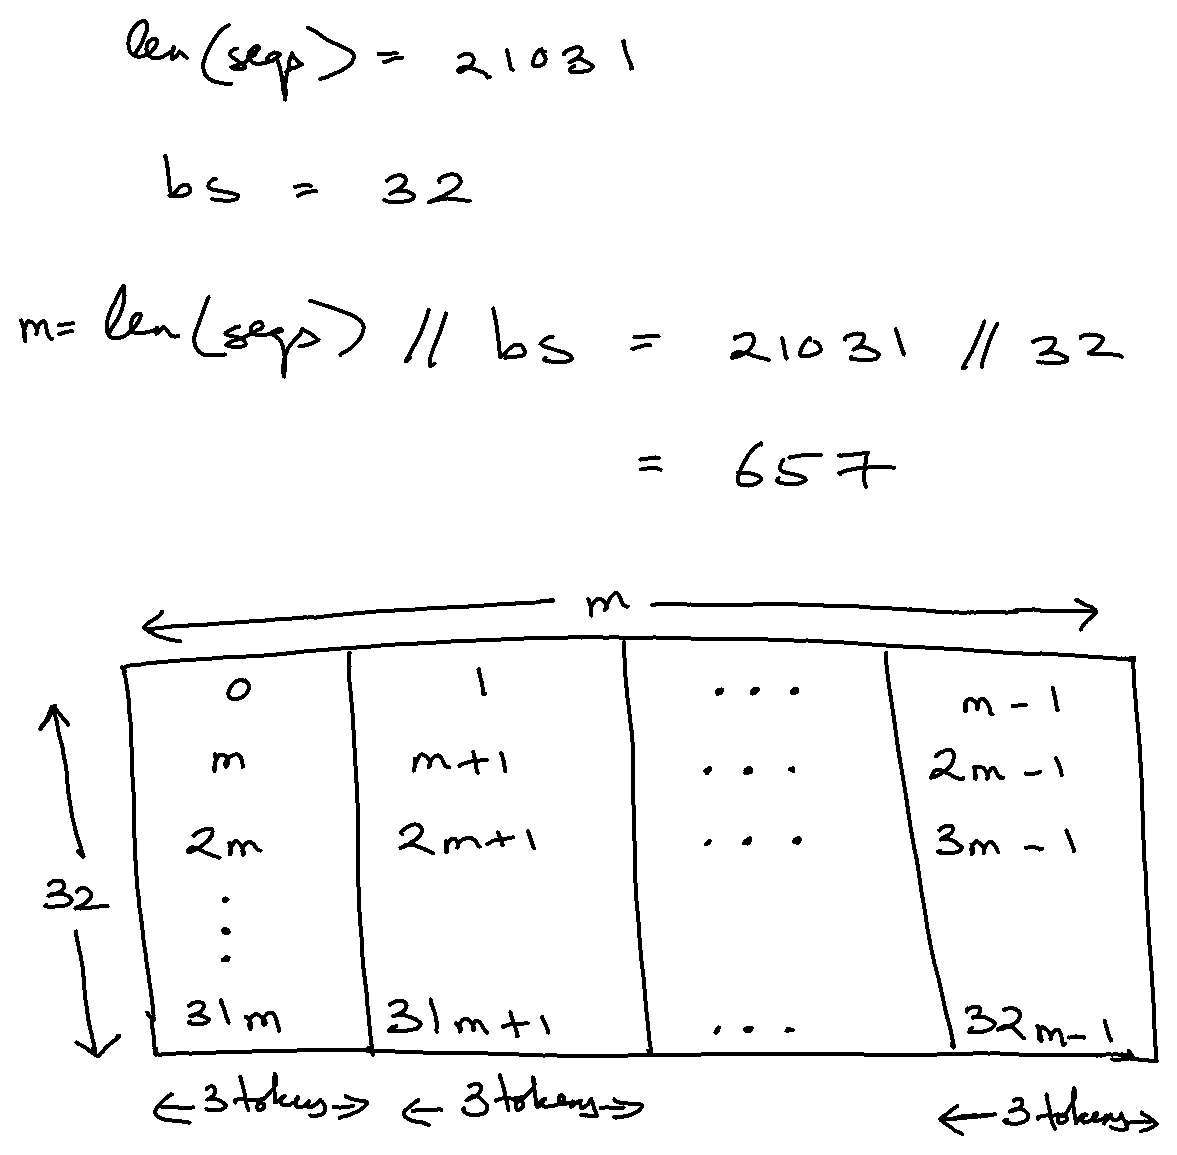

In [68]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m):
        new_ds += L(ds[i + m * j] for j in range(bs))
    return new_ds

The first batch will be composed of the samples `(0, m, 2 * m, ..., (bs - 1) * m)`, the second batch will be composed of the samples `(1, m + 1, 2 * m + 1, ..., (bs - 1) * m + 1)`, and so on... The inner loop is going down the columns. The outer loop is going across the rows.

In [69]:
rearranged_seqs = group_chunks(seqs, bs)
rearranged_seqs

(#21024) [(tensor([0, 1, 2]), 1),(tensor([ 1,  4, 28]), 24),(tensor([26,  1,  8]), 28),(tensor([ 1,  0, 29]), 2),(tensor([4, 1, 0]), 29),(tensor([20,  8,  1]), 0),(tensor([23,  0,  1]), 2),(tensor([28, 22,  5]), 1),(tensor([ 7, 28, 21]), 9),(tensor([ 1,  3, 29]), 22)...]

In [70]:
rearranged_seqs[0]

(tensor([0, 1, 2]), 1)

In [71]:
rearranged_seqs[32]

(tensor([1, 3, 1]), 4)

**Note:** The second element in `seqs` has become the thirty third element in `rearranged_seqs`.

In [72]:
cut = int(len(seqs) * 0.8)
cut

16824

In [73]:
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs),
    group_chunks(seqs[cut:], bs),
    bs=bs,
    drop_last=True,
    shuffle=False
)

In [74]:
16824 // 32

525

In [75]:
len(dls.train)

525

In [76]:
x, y = next(iter(dls.train))
x.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

In [77]:
model = LMModel3(len(vocab), 64)
model

LMModel3(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [78]:
# Test:
with torch.no_grad():
    output = model(x)
output.shape

torch.Size([32, 30])

In [87]:
model_alt = LMModel3Alt(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt

LMModel3Alt(
  (emb): Embedding(30, 64)
  (rnn): SimpleRNNStateful(
    (i_h): Linear(in_features=64, out_features=128, bias=True)
    (h_h): Linear(in_features=128, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [88]:
# Test:
with torch.no_grad():
    output = model_alt(x)
output.shape

torch.Size([32, 30])

In [96]:
model_alt2 = LMModel3Alt2(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt2

LMModel3Alt2(
  (emb): Embedding(30, 64)
  (rnn): RNNCell(64, 128)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [97]:
# Test:
with torch.no_grad():
    output = model_alt2(x)
output.shape

torch.Size([32, 30])

In [104]:
model_alt3 = LMModel3Alt3(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=False)
model_alt3

LMModel3Alt3(
  (emb): Embedding(30, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [105]:
# Test:
with torch.no_grad():
    output = model_alt3(x)
output.shape

torch.Size([32, 30])

In [89]:
model.reset()
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.498798,1.742323,0.484256,00:05
1,1.164119,1.689535,0.453960,00:04
2,1.027975,1.718138,0.495229,00:04
3,0.972684,1.877180,0.543416,00:05
4,0.952699,1.813588,0.553674,00:04
5,0.947687,1.723938,0.536021,00:04
6,0.941458,1.759222,0.544609,00:05
7,0.910977,1.705199,0.560353,00:04
8,0.873374,1.818613,0.567032,00:04
9,0.854535,1.848573,0.567271,00:05


In [90]:
model_alt.reset()
learn = Learner(dls, model_alt, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.478031,1.730701,0.455630,00:05
1,1.082841,1.636926,0.458492,00:06
2,0.985360,1.658197,0.509065,00:04
3,0.962140,1.624847,0.529103,00:05
4,0.970779,1.615860,0.537691,00:05
5,0.939001,1.525761,0.555105,00:04
6,0.942902,1.486618,0.561546,00:06
7,0.914602,1.475283,0.570611,00:05
8,0.858734,1.454241,0.592080,00:04
9,0.838070,1.466927,0.596135,00:06


In [98]:
model_alt2.reset()
learn = Learner(dls, model_alt2, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.471323,1.710472,0.487834,00:06
1,1.069962,1.621686,0.480677,00:05
2,0.999121,1.569430,0.523378,00:05
3,0.988791,1.607360,0.543416,00:06
4,0.913061,1.554841,0.560353,00:05
5,0.979376,1.487215,0.548187,00:06
6,0.944388,1.421582,0.560115,00:04
7,0.932041,1.454480,0.573712,00:04
8,0.889424,1.434849,0.586594,00:07
9,0.855925,1.448068,0.595420,00:05


In [106]:
model_alt3.reset()
learn = Learner(dls, model_alt3, loss_func=F.cross_entropy, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.483872,1.787058,0.401718,00:05
1,1.080464,1.602044,0.475906,00:04
2,1.011189,1.622901,0.461832,00:05
3,0.991889,1.622690,0.529819,00:05
4,0.970380,1.599558,0.541746,00:04
5,0.959774,1.558498,0.536260,00:05
6,0.944571,1.519980,0.565363,00:05
7,0.913819,1.359177,0.566078,00:04
8,0.871988,1.435637,0.578244,00:05
9,0.840539,1.472258,0.587071,00:05


### Creating More Signal

In [107]:
sl = 16
seqs = L((tensor(nums[i:i + sl]), tensor(nums[i + 1:i + sl + 1])) for i in range(0, len(nums) - sl - 1, sl))
seqs

(#3943) [(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]), tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9])),(tensor([ 9,  1, 10,  1, 11,  1, 12,  1, 13,  1, 14,  1, 15,  1, 16,  1]), tensor([ 1, 10,  1, 11,  1, 12,  1, 13,  1, 14,  1, 15,  1, 16,  1, 17])),(tensor([17,  1, 18,  1, 19,  1, 20,  1, 20,  0,  1, 20,  2,  1, 20,  3]), tensor([ 1, 18,  1, 19,  1, 20,  1, 20,  0,  1, 20,  2,  1, 20,  3,  1])),(tensor([ 1, 20,  4,  1, 20,  5,  1, 20,  6,  1, 20,  7,  1, 20,  8,  1]), tensor([20,  4,  1, 20,  5,  1, 20,  6,  1, 20,  7,  1, 20,  8,  1, 20])),(tensor([20,  9,  1, 21,  1, 21,  0,  1, 21,  2,  1, 21,  3,  1, 21,  4]), tensor([ 9,  1, 21,  1, 21,  0,  1, 21,  2,  1, 21,  3,  1, 21,  4,  1])),(tensor([ 1, 21,  5,  1, 21,  6,  1, 21,  7,  1, 21,  8,  1, 21,  9,  1]), tensor([21,  5,  1, 21,  6,  1, 21,  7,  1, 21,  8,  1, 21,  9,  1, 22])),(tensor([22,  1, 22,  0,  1, 22,  2,  1, 22,  3,  1, 22,  4,  1, 22,  5]), tensor([ 1, 22,  0,  1, 22,  2,  1, 22,  3,  1, 22,  4

In [108]:
seqs[0]

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]),
 tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9]))

In [109]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs),
    group_chunks(seqs[cut:], bs),
    bs=bs,
    drop_last=True,
    shuffle=False
)

In [110]:
x, y = next(iter(dls.train))
x.shape, y.shape

(torch.Size([32, 16]), torch.Size([32, 16]))

In [111]:
# Reminder:
seqs[0]

(tensor([0, 1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1]),
 tensor([1, 2, 1, 3, 1, 4, 1, 5, 1, 6, 1, 7, 1, 8, 1, 9]))

In [113]:
# Reminder:
vocab

(#30) ['one','.','two','three','four','five','six','seven','eight','nine'...]

In [114]:
[L(vocab[o] for o in s) for s in seqs[0]]

[(#16) ['one','.','two','.','three','.','four','.','five','.'...],
 (#16) ['.','two','.','three','.','four','.','five','.','six'...]]

In [115]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.h_h = nn.Linear(n_hidden, n_hidden)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = 0

    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:, i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)

    def reset(self):
        self.h = 0

**Note:** `sl` is being picked up from the global namespace.

In [123]:
model = LMModel4(len(vocab), 64)
model

LMModel4(
  (i_h): Embedding(30, 64)
  (h_h): Linear(in_features=64, out_features=64, bias=True)
  (h_o): Linear(in_features=64, out_features=30, bias=True)
)

In [124]:
# Test:
with torch.no_grad():
    logits = model(x)
logits.shape

torch.Size([32, 16, 30])

In [125]:
targets = y
targets.shape

torch.Size([32, 16])

To use `F.cross_entropy`, we need to reshape the logits and targets.

In [126]:
logits.view(-1, len(vocab)).shape

torch.Size([512, 30])

In [127]:
targets.view(-1).shape

torch.Size([512])

In [128]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [129]:
model.reset()
learn = Learner(dls, model, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.820750,2.493289,0.305257,00:02
1,1.715505,1.843506,0.411621,00:02
2,1.413977,1.848683,0.463135,00:01
3,1.216401,1.681567,0.482666,00:01
4,1.035639,1.571302,0.481527,00:01
5,0.837167,1.606419,0.500163,00:01
6,0.706436,1.510629,0.525635,00:01
7,0.627138,1.327492,0.582031,00:01
8,0.560145,1.194417,0.622396,00:02
9,0.514664,1.275698,0.615804,00:02


In [130]:
model_alt = LMModel3Alt(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=True)
model_alt

LMModel3Alt(
  (emb): Embedding(30, 64)
  (rnn): SimpleRNNStateful(
    (i_h): Linear(in_features=64, out_features=128, bias=True)
    (h_h): Linear(in_features=128, out_features=128, bias=True)
  )
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [131]:
# Test:
with torch.no_grad():
    logits = model_alt(x)
logits.shape

torch.Size([32, 16, 30])

In [132]:
model_alt.reset()
learn = Learner(dls, model_alt, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.299101,1.929870,0.471598,00:02
1,1.605652,1.860847,0.367839,00:02
2,1.405675,1.843909,0.485189,00:02
3,1.197719,1.753207,0.529460,00:02
4,1.000475,1.552671,0.578288,00:02
5,0.848223,1.498886,0.604574,00:02
6,0.716819,1.518034,0.622233,00:02
7,0.614500,1.530645,0.626383,00:02
8,0.552015,1.586838,0.636882,00:02
9,0.487866,1.564973,0.665120,00:02


In [133]:
model_alt2 = LMModel3Alt2(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=True)
model_alt2

LMModel3Alt2(
  (emb): Embedding(30, 64)
  (rnn): RNNCell(64, 128)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [134]:
# Test:
with torch.no_grad():
    logits = model_alt2(x)
logits.shape

torch.Size([32, 16, 30])

In [135]:
model_alt2.reset()
learn = Learner(dls, model_alt2, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.388109,1.987374,0.466390,00:01
1,1.611572,1.787286,0.459961,00:02
2,1.382553,1.831302,0.487630,00:02
3,1.200116,1.835692,0.510498,00:01
4,1.019086,1.835817,0.548747,00:01
5,0.857534,1.794486,0.569336,00:01
6,0.733162,1.894485,0.580322,00:02
7,0.634630,1.890308,0.578613,00:02
8,0.561239,1.878065,0.594157,00:02
9,0.501314,1.894531,0.618815,00:02


In [136]:
model_alt3 = LMModel3Alt3(bs=bs, vocab_size=len(vocab), input_emb_size=64, hidden_size=128, nonlinearity='tanh', return_sequences=True)
model_alt3

LMModel3Alt3(
  (emb): Embedding(30, 64)
  (rnn): RNN(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=30, bias=True)
)

In [137]:
# Test:
with torch.no_grad():
    logits = model_alt3(x)
logits.shape

torch.Size([32, 16, 30])

In [138]:
model_alt3.reset()
learn = Learner(dls, model_alt3, loss_func=loss_func, metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.345664,1.923041,0.467855,00:01
1,1.613324,1.861885,0.398926,00:01
2,1.373003,1.744215,0.497070,00:02
3,1.152012,1.717458,0.499105,00:02
4,0.974674,1.758620,0.540446,00:01
5,0.822125,1.801135,0.587158,00:01
6,0.691558,1.847366,0.618734,00:01
7,0.590517,1.768564,0.618327,00:01
8,0.509639,1.859188,0.629557,00:01
9,0.461319,1.895708,0.643717,00:01


## Multilayer RNNs

### The Model

In [ ]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden) # bs is being picked up from the global namespace.

    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)

    def reset(self): self.h.zero_()

As in stateful RNNs in Keras, this network only works with a particular batch size.

In [ ]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

### Exploding or Disappearing Activations

## LSTM

### Building an LSTM from Scratch

In [ ]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.forget_gate = nn.Linear(ni + nh, nh)
        self.input_gate  = nn.Linear(ni + nh, nh)
        self.cell_gate   = nn.Linear(ni + nh, nh)
        self.output_gate = nn.Linear(ni + nh, nh)

    def forward(self, input, state):
        h,c = state
        h = torch.cat([h, input], dim=1)
        forget = torch.sigmoid(self.forget_gate(h))
        c = c * forget
        inp = torch.sigmoid(self.input_gate(h))
        cell = torch.tanh(self.cell_gate(h))
        c = c + inp * cell
        out = torch.sigmoid(self.output_gate(h))
        h = out * torch.tanh(c)
        return h, (h,c)

In [ ]:
class LSTMCell(Module):
    def __init__(self, ni, nh):
        self.ih = nn.Linear(ni,4*nh)
        self.hh = nn.Linear(nh,4*nh)

    def forward(self, input, state):
        h,c = state
        # One big multiplication for all the gates is better than 4 smaller ones
        gates = (self.ih(input) + self.hh(h)).chunk(4, 1)
        ingate,forgetgate,outgate = map(torch.sigmoid, gates[:3])
        cellgate = gates[3].tanh()

        c = (forgetgate*c) + (ingate*cellgate)
        h = outgate * c.tanh()
        return h, (h,c)

In [ ]:
t = torch.arange(0,10); t

In [ ]:
t.chunk(2)

### Training a Language Model Using LSTMs

In [ ]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]

    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)

    def reset(self):
        for h in self.h: h.zero_()

In [ ]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

## Regularizing an LSTM

### Dropout

In [ ]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

### Activation Regularization and Temporal Activation Regularization

### Training a Weight-Tied Regularized LSTM

In [ ]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]

    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out

    def reset(self):
        for h in self.h: h.zero_()

In [ ]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [ ]:
learn = TextLearner(dls, LMModel7(len(vocab), 64, 2, 0.4),
                    loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [ ]:
learn.fit_one_cycle(15, 1e-2, wd=0.1)

## Conclusion

## Questionnaire

1. If the dataset for your project is so big and complicated that working with it takes a significant amount of time, what should you do?
1. Why do we concatenate the documents in our dataset before creating a language model?
1. To use a standard fully connected network to predict the fourth word given the previous three words, what two tweaks do we need to make to our model?
1. How can we share a weight matrix across multiple layers in PyTorch?
1. Write a module that predicts the third word given the previous two words of a sentence, without peeking.
1. What is a recurrent neural network?
1. What is "hidden state"?
1. What is the equivalent of hidden state in ` LMModel1`?
1. To maintain the state in an RNN, why is it important to pass the text to the model in order?
1. What is an "unrolled" representation of an RNN?
1. Why can maintaining the hidden state in an RNN lead to memory and performance problems? How do we fix this problem?
1. What is "BPTT"?
1. Write code to print out the first few batches of the validation set, including converting the token IDs back into English strings, as we showed for batches of IMDb data in <<chapter_nlp>>.
1. What does the `ModelResetter` callback do? Why do we need it?
1. What are the downsides of predicting just one output word for each three input words?
1. Why do we need a custom loss function for `LMModel4`?
1. Why is the training of `LMModel4` unstable?
1. In the unrolled representation, we can see that a recurrent neural network actually has many layers. So why do we need to stack RNNs to get better results?
1. Draw a representation of a stacked (multilayer) RNN.
1. Why should we get better results in an RNN if we call `detach` less often? Why might this not happen in practice with a simple RNN?
1. Why can a deep network result in very large or very small activations? Why does this matter?
1. In a computer's floating-point representation of numbers, which numbers are the most precise?
1. Why do vanishing gradients prevent training?
1. Why does it help to have two hidden states in the LSTM architecture? What is the purpose of each one?
1. What are these two states called in an LSTM?
1. What is tanh, and how is it related to sigmoid?
1. What is the purpose of this code in `LSTMCell`: `h = torch.cat([h, input], dim=1)`
1. What does `chunk` do in PyTorch?
1. Study the refactored version of `LSTMCell` carefully to ensure you understand how and why it does the same thing as the non-refactored version.
1. Why can we use a higher learning rate for `LMModel6`?
1. What are the three regularization techniques used in an AWD-LSTM model?
1. What is "dropout"?
1. Why do we scale the acitvations with dropout? Is this applied during training, inference, or both?
1. What is the purpose of this line from `Dropout`: `if not self.training: return x`
1. Experiment with `bernoulli_` to understand how it works.
1. How do you set your model in training mode in PyTorch? In evaluation mode?
1. Write the equation for activation regularization (in math or code, as you prefer). How is it different from weight decay?
1. Write the equation for temporal activation regularization (in math or code, as you prefer). Why wouldn't we use this for computer vision problems?
1. What is "weight tying" in a language model?

### Further Research

1. In ` LMModel2`, why can `forward` start with `h=0`? Why don't we need to say `h=torch.zeros(...)`?
1. Write the code for an LSTM from scratch (you may refer to <<lstm>>).
1. Search the internet for the GRU architecture and implement it from scratch, and try training a model. See if you can get results similar to those we saw in this chapter. Compare your results to the results of PyTorch's built in `GRU` module.
1. Take a look at the source code for AWD-LSTM in fastai, and try to map each of the lines of code to the concepts shown in this chapter.